In [1]:

# Metrics to Calculate:

# ROI (Return on Investment)
# PnL (Profit and Loss)
# Sharpe Ratio
# MDD (Maximum Drawdown)
# Win Rate
# Win Positions
# Total Positionsitions

### Importing pre-requisities...

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import ast
from pprint import pprint

In [3]:
data = pd.read_csv(r"C:\Users\navab\Downloads\TRADES_CopyTr_90D_ROI.csv")
data.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [4]:
data.shape

(150, 2)

In [5]:
data.isnull().sum()

Port_IDs         0
Trade_History    1
dtype: int64

In [6]:
# ast.literal_eval(data.iloc[0,1])[0]

In [7]:
data.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


### Feature Engineering

In [8]:
def roi(rp,fee,quantity):
    return (rp-fee)/quantity
def pnl(rp,fee):
    return (rp-fee)
def sharpe_ratio(returns,rf=0.02):
    return (np.mean(np.array(returns))-rf)/np.std(np.array(returns))
    
def maximum_drawdown(prices, total):
    weights = []
    sym_arrays = []
    for sym in prices.values():
        weights.append(sum(sym) / total)
        sym_arrays.append(sym)

    weights = np.array(weights)
    df_prices = pd.DataFrame(sym_arrays).T
    df_prices.fillna(0, inplace=True)

    weighted_prices = np.dot(df_prices, weights)
    prices_series = pd.Series(weighted_prices)

    cumulative_max = prices_series.cummax()
    drawdown = (prices_series - cumulative_max) / cumulative_max

    max_drawdown = drawdown.min()
    drawdown_duration = (drawdown == max_drawdown).sum()

    return max_drawdown, drawdown_duration




In [9]:
def process_data(data):
    scores = []
    rois = []
    sharpe = []
    PnL = []
    win = []
    drawdown = []
    duration = []
    win_positions = []
    total_positions = []
    for ind in range(data.shape[0]):
        z = data.iloc[ind, 1]
        if pd.isna(z):
            scores.append(np.nan)
            rois.append(np.nan)
            sharpe.append(np.nan)
            PnL.append(np.nan)
            win.append(np.nan)
            drawdown.append(np.nan)
            duration.append(np.nan)
            win_positions.append(np.nan)
            total_positions.append(np.nan)
            continue
            
        x = ast.literal_eval(z)
        returns = []
        prices = dict()
        no_win, tot, fee, quantity, rp, tot_price = 0, 0, 0, 0, 0, 0

        for i in x:
            if i['symbol'] not in prices:
                prices[i['symbol']] = []

            if i['side'] == 'SELL':
                tot += 1
                if i['realizedProfit'] - i['fee'] > 0:
                    no_win += 1

            fee += i['fee']
            quantity += i['quantity']
            rp += i['realizedProfit']
            prices[i['symbol']].append(i['price'])
            tot_price += i['price']
            returns.append(i['realizedProfit'] - i['fee'])

        win_positions.append(no_win)
        total_positions.append(tot)
        roi_value = roi(rp, fee, quantity)
        pnl_value = pnl(rp, fee)
        sharpe_ratio_value = sharpe_ratio(returns)
        win_rate = no_win / tot if tot != 0 else 0
        max_drawdown_value, drawdown_duration = maximum_drawdown(prices, tot_price)
        # score = ((0.25*roi_value) * (0.15*pnl_value) * (0.25*sharpe_ratio_value) * (0.35*win_rate)) / (0.2*abs(max_drawdown_value) + 1e-5)
        # scores.append(score)
        rois.append(roi_value)
        sharpe.append(sharpe_ratio_value)
        PnL.append(pnl_value)
        win.append(win_rate)
        drawdown.append(max_drawdown_value)
        duration.append(drawdown_duration)
        # print(f"Score: {score}")
        # print(f"ROI: {roi_value:4f}")
        # print(f"PnL: {pnl_value:.4f}")
        # print(f"Sharpe Ratio: {sharpe_ratio_value:.4f}")
        # print(f"Win Rate: {win_rate:.4f}")
        # print(f"Maximum Drawdown: {max_drawdown_value * 100:.4f}%")
    return pd.DataFrame(data=list(zip(rois,PnL,sharpe,win,drawdown,duration,win_positions,total_positions)),columns = ['roi','PnL','sharpe_ratio','win_rate','max_drawdown','drawdown_duration','win_positions','total_positions'])

In [10]:
metrics = process_data(data)

In [11]:
metrics.head()

,roi,PnL,sharpe_ratio,win_rate,max_drawdown,drawdown_duration,win_positions,total_positions
0,0.004174,7550.790845,0.295538,1.000000,-0.999987,4.0,591.0,591.0
1,0.025296,3742.297988,0.127016,0.972028,-1.000000,4.0,278.0,286.0
2,0.002065,1019.625266,0.090270,0.998652,-0.999997,1.0,741.0,742.0
3,0.008783,3879.612549,0.124323,0.873832,-1.000000,13.0,374.0,428.0
4,0.001855,1792.802337,0.069256,0.993902,-0.984464,1.0,163.0,164.0


In [12]:
scaler = MinMaxScaler()
X = metrics.drop('max_drawdown',axis=1)
scaled_metrics = pd.DataFrame(data=scaler.fit_transform(X),columns = ['roi','PnL','sharpe_ratio','win_rate','drawdown_duration','win_positions','total_positions'])

In [13]:
scaled_metrics = pd.concat([scaled_metrics,metrics['max_drawdown']],axis=1)

### Analysing the Metrics

In [118]:
metrics['score'] = scaled_metrics.apply(
    lambda x: ((0.22 * x['roi']) * 
              (0.2 * x['PnL']) * 
              (0.2 * x['sharpe_ratio']) * 
               (0.01 * x['win_positions']) *
              (0.17 * x['win_rate']) )/
              (0.2 * abs(x['max_drawdown']) + 1e-5), 
    axis=1
)

In [119]:
df = pd.concat([data,metrics],axis=1)

In [120]:
df.describe()

,Port_IDs,roi,PnL,sharpe_ratio,win_rate,max_drawdown,drawdown_duration,win_positions,total_positions,score
count,1.500000e+02,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,1.490000e+02
mean,3.975655e+18,0.010697,5180.689091,0.201248,0.915583,-0.758338,3.704698,629.288591,697.885906,2.003550e-06
std,6.887470e+16,0.014720,8618.862056,0.140212,0.139861,0.387710,5.725126,842.369007,941.072135,2.200208e-05
min,3.672755e+18,-0.001385,-9154.871620,-0.059464,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,3.943672e+18,0.003023,1929.845001,0.101142,0.873832,-1.000000,1.000000,78.000000,78.000000,8.560222e-09
50%,3.998616e+18,0.006151,2931.681473,0.182137,0.979508,-0.999190,2.000000,241.000000,268.000000,2.871602e-08
75%,4.029508e+18,0.011193,5387.244142,0.275526,1.000000,-0.505564,4.000000,792.000000,834.000000,8.146228e-08
max,4.041860e+18,0.122016,83347.153462,0.721101,1.000000,0.000000,60.000000,3254.000000,3283.000000,2.686046e-04


In [121]:
df['rank'] = df['score'].rank(ascending=0)

In [122]:
df = df.sort_values(by='rank').reset_index().drop('index',axis=1)

### Result - TOP 20

In [123]:
result = df.drop('Trade_History',axis=1)

In [124]:
result.head(20).to_csv('top 20 Port_IDs.csv')

In [125]:
result.head(20)

,Port_IDs,roi,PnL,sharpe_ratio,win_rate,max_drawdown,drawdown_duration,win_positions,total_positions,score,rank
0,4030708912786799105,0.032365,1630.720547,0.187100,1.000000,0.000000,60.0,58.0,58.0,2.686046e-04,1.0
1,4020204877254599680,0.003607,83347.153462,0.069827,0.765469,-0.043238,10.0,2301.0,3006.0,6.267176e-06,2.0
2,4039129759104249600,0.032061,1281.718643,0.526806,1.000000,-0.005682,1.0,56.0,56.0,5.158056e-06,3.0
3,4029749871687083265,0.032205,3719.889100,0.356479,1.000000,-0.052826,1.0,521.0,521.0,4.572733e-06,4.0
4,4037717032428033792,0.027840,1929.845001,0.223977,1.000000,-0.020698,2.0,170.0,170.0,1.941061e-06,5.0
5,4022641794255717633,0.018677,2200.396616,0.533768,1.000000,-0.997602,1.0,2923.0,2923.0,1.021534e-06,6.0
6,4028701921959171840,0.004562,19753.162333,0.300148,0.970588,-0.049710,1.0,297.0,306.0,9.240050e-07,7.0
7,4022565861939831809,0.002769,16866.053765,0.346517,0.958904,-0.046790,1.0,350.0,365.0,8.112398e-07,8.0
8,3999240873283311617,0.005676,44446.918627,0.233650,1.000000,-0.999999,3.0,2063.0,2063.0,5.904401e-07,9.0
9,3944088772635000577,0.007572,8098.270351,0.310413,1.000000,-0.999942,1.0,3254.0,3254.0,4.798552e-07,10.0


<Axes: >

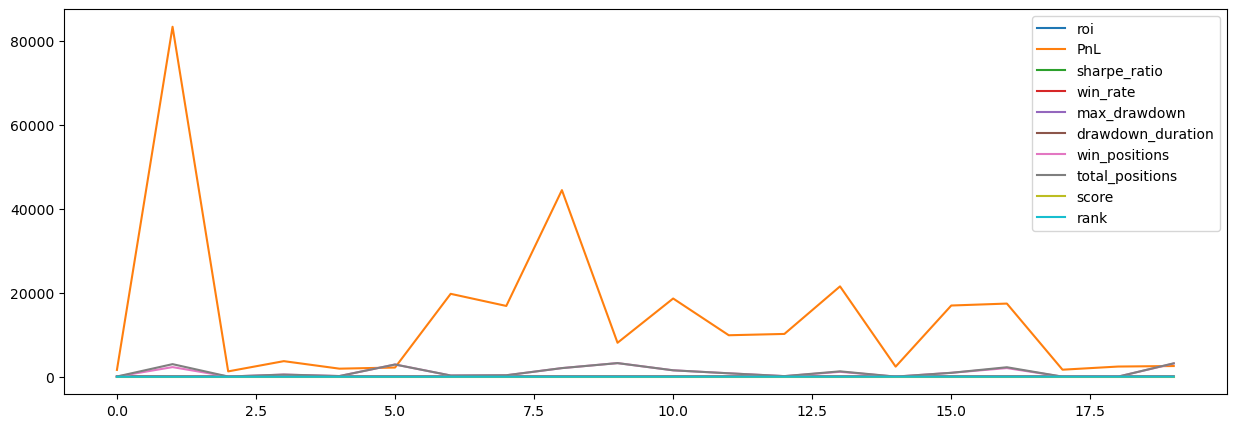

In [126]:
result.iloc[:20,1:].plot(figsize=(15,5))

### Thank You
-- Abubacker S <br>
-- https://linkedin.com/in/abubacker10 <br>
-- https://github.com/abubacker10 <br>